In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

from layer import L_layer_model_Classifier, L_layer_model_Regression
from sklearn.metrics import mean_squared_log_error

### load data and Preprocessing

In [2]:
dataset = np.load("data/nyc_taxi_data.npy", allow_pickle=True).item()
X_train, y_train, X_test, y_test = dataset["X_train"], dataset["y_train"], dataset["X_test"], dataset["y_test"]

In [3]:

def get_distance(lat1, lon1, lat2, lon2):
    # Calculate distance by latitude and longitude

    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat1 - lat1
    dlon = lon1 - lon2

    # Haversine
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    R = 6371  # Radius of the Earth in kilometers
    distance = R * c

    return distance

def dataset_Preprocessing(X,y):
    transform_data = pd.DataFrame(X)
    transform_data['pickup_datetime'] = pd.to_datetime(transform_data['pickup_datetime'])

    transform_data['pickup_weekday'] = transform_data['pickup_datetime'].dt.dayofweek
    transform_data['pickup_month'] = transform_data['pickup_datetime'].dt.month
    transform_data['pickup_hour'] = transform_data['pickup_datetime'].dt.hour
#     transform_data['pickup_time'] = transform_data['pickup_datetime'].dt.minute
    
#     transform_data['dropoff_datetime'] = pd.to_datetime(transform_data['dropoff_datetime'])
#     transform_data['dropoff_weekday'] = transform_data['dropoff_datetime'].dt.dayofweek
#     transform_data['dropoff_month'] = transform_data['dropoff_datetime'].dt.month
#     transform_data['dropoff_hour'] = transform_data['dropoff_datetime'].dt.hour
#     transform_data['dropoff_time'] = transform_data['dropoff_datetime'].dt.minute

    # transform_data['store_and_fwd_flag'] = transform_data.store_and_fwd_flag.map({'N': 0, 'Y': 1})
    mean_longitude = np.mean(transform_data['pickup_longitude'])
    mean_latitude = np.mean(transform_data['pickup_latitude'])
    transform_data.loc[:, 'long'] = transform_data['pickup_longitude'] - mean_longitude
    transform_data.loc[:, 'lat'] = transform_data['pickup_latitude'] - mean_latitude

    transform_data['distance'] = transform_data.apply(
        lambda row: get_distance(row['pickup_latitude'], row['pickup_longitude'],
                                 row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    transform_data.drop(["id","vendor_id","pickup_longitude", "pickup_latitude","dropoff_longitude", "dropoff_latitude", 'pickup_datetime', 'dropoff_datetime','passenger_count','store_and_fwd_flag'],
                        axis=1,inplace=True)

#     transform_target = np.array(y).reshape(-1, 1)
    transform_target = pd.DataFrame(y)

    return transform_data,transform_target

def show_score(model, picname, times=10):
    '''
    show train_score and val_score plot with times parameter
    '''
    #get train_score and val_score with times parameter
    train_scores = model.train_losses[::times]
    val_scores = model.val_losses[::times]

    #draw plot
    plt.plot(train_scores, label='Train Cost')
    plt.plot(val_scores, label='Validation Cost')
    plt.ylabel('cost')
    plt.xlabel('epoch ( per ' + str(times) + ' )')
    plt.title(picname)
    plt.legend()
    plt.show()


In [4]:
X_train_act,y_train_act = dataset_Preprocessing(X_train,y_train)
X_test_act,y_test_act= dataset_Preprocessing(X_test,y_test)

#### Removing anomalous data from the training dataset

In [5]:
X_train_act =X_train_act.loc[(y_train_act["trip_duration"]<7000) & (X_train_act["distance"]<20)]
y_train_act=y_train_act.loc[(y_train_act["trip_duration"]<7000) & (X_train_act["distance"]<20)]
X_train_act 

,pickup_weekday,pickup_month,pickup_hour,long,lat,distance
879655,4,1,23,0.017948,0.022419,1.523373
646838,5,3,9,0.011318,0.012673,1.532464
1138713,5,4,16,-0.003986,0.000916,2.881768
864716,2,1,11,0.003498,0.011437,0.567329
434927,6,6,9,0.023152,0.020634,1.501560
...,...,...,...,...,...,...
259178,4,3,7,0.018467,0.026402,4.309589
1414414,1,2,18,-0.000118,0.012993,0.861745
131932,1,1,19,-0.032696,-0.016643,4.766057
671155,1,1,11,0.011158,0.016396,0.624516


### standardization

In [6]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler()
scaler1 = StandardScaler()
X_train_sd = scaler.fit_transform(X_train_act)
X_test_sd =scaler.transform(X_test_act)
y_train_sd = scaler1.fit_transform(y_train_act)
y_test_sd =scaler1.transform(y_test_act)

### model1  with one hidden layer and 7 notes with learning_rate=1 training

In [7]:
model1 = L_layer_model_Regression(layer_dims=[6,7,1],active_function='relu',learning_rate=1,random_state=12)
model1.fit(X_train_sd,y_train_sd,print_cost=True)


 after epoch 0: Train cost: 1.507461, Validation cost: 2.746636
 after epoch 82: Train cost: 0.231080, Validation cost: 0.230321


In [8]:
y_test_act_1 = np.array(y_test_act)
test_pred_sd =model1.predict(X_test_sd)
test_pred_normal = scaler1.inverse_transform(test_pred_sd)
test_score1 = mean_squared_log_error( y_test_act_1,abs(test_pred_normal))
print(f'RMSLE of test set = {test_score1}')

RMSLE of test set = 0.38653184317227984


 it trains 90 epochs, and the score on the test set is 0.386

In [9]:
test_pred_df1 = pd.DataFrame(test_pred_normal, columns=['trip_duration'])
test_pred_df1.index = y_test_act.index
test_pred_df1["trip_duration_actural"] = y_test_act["trip_duration"]
test_pred_df1

,trip_duration,trip_duration_actural
67250,530.264322,1040
1397036,578.809349,827
1021087,624.424853,614
951424,542.542221,867
707882,2789.824376,4967
...,...,...
526279,448.681651,395
80354,451.235755,779
328645,2727.199994,2344
657429,445.971469,393


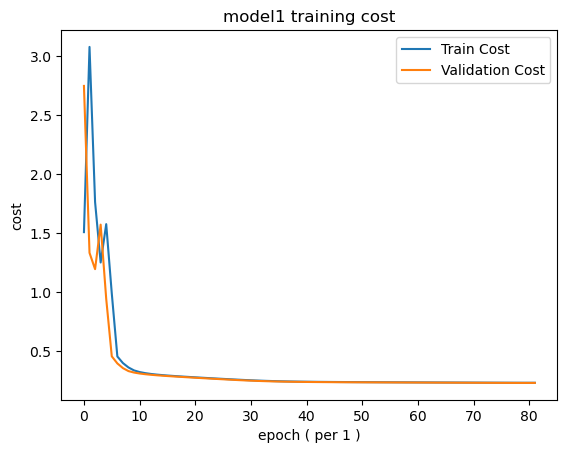

In [10]:
show_score(model1,'model1 training cost',times=1)

In [11]:
print(model1.model.layers[0].weights)
print(model1.model.layers[2].weights)

[[ 0.2908971   0.24228322 -1.28781698 -0.44860165  0.07956225 -0.41860723
  -1.0409437 ]
 [-0.22906225 -0.04495781  0.23194231 -0.59169054  0.33117533 -0.45375304
  -0.00490904]
 [ 0.1652581  -0.05542272  0.28951932  0.00726239  0.04258078  0.10437933
  -0.43656421]
 [ 0.17584925  0.06521204 -0.13425249 -0.52117206 -0.18088972  0.74328284
   0.01304539]
 [ 0.03994388  0.12180395  0.11260124 -0.02046112  0.00826532  0.17671341
   0.07444389]
 [-0.04235614  0.0046471   0.07567646  0.03946212  0.11727709  0.01329298
  -0.03040826]
 [ 1.03073796 -1.03217152 -0.62880265 -0.14075685 -0.7989129  -0.03912232
  -0.13237372]]
[[ 0.35424224]
 [ 0.49477042]
 [-0.65756358]
 [ 1.28298268]
 [-0.34470636]
 [-0.49269786]
 [-0.5080863 ]
 [ 0.54329744]]


### model2  with one hidden layer and 7 notes  with learning_rate=0.7 and active_function='sigmoid' training

 after epoch 0: Train cost: 0.544701, Validation cost: 0.492192
 after epoch 17: Train cost: 0.294076, Validation cost: 0.299864
RMSLE of test set = 0.43882054053562497


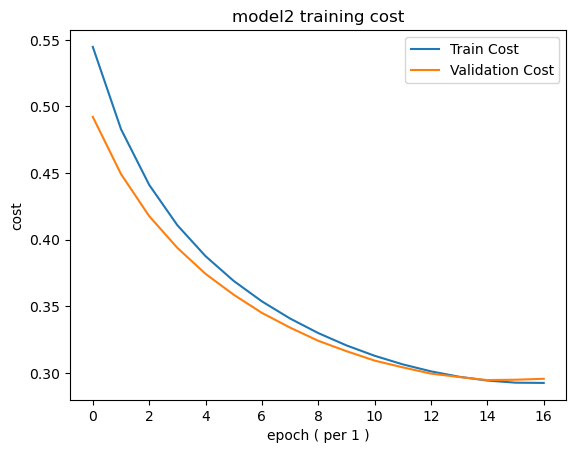

,trip_duration,trip_duration_actural
67250,534.554157,1040
1397036,481.456499,827
1021087,555.689631,614
951424,543.409029,867
707882,2125.906642,4967
...,...,...
526279,553.473430,395
80354,367.997583,779
328645,2172.113669,2344
657429,509.729053,393


In [12]:
model2 = L_layer_model_Regression(layer_dims=[6,7,1],active_function='sigmoid',learning_rate=0.7,random_state=12)
model2.fit(X_train_sd,y_train_sd,print_cost=True)
test_pred_sd2 = model2.predict(X_test_sd)
test_pred_normal2 = scaler1.inverse_transform(test_pred_sd2)
test_score2 = mean_squared_log_error( y_test_act_1,abs(test_pred_normal2))
print(f'RMSLE of test set = {test_score2}')

show_score(model2,'model2 training cost',times=1)

test_pred_df2 = pd.DataFrame(test_pred_normal2, columns=['trip_duration'])
test_pred_df2.index = y_test_act.index
test_pred_df2["trip_duration_actural"] = y_test_act["trip_duration"]

test_pred_df2

**it trains 16 epochs, and the score on the test set is  0.4388**

In [13]:
print(model2.model.__dict__)
print(model2.model.layers[2].weights)


{'layers': [<layer.Linear object at 0x00000226BEE35E90>, <layer.Sigmoid object at 0x00000226B30DEDD0>, <layer.Linear object at 0x00000226BEDF3810>]}
[[ 0.34603686]
 [ 1.02354446]
 [ 0.026647  ]
 [-0.54517487]
 [-0.29128957]
 [-0.2409125 ]
 [ 1.0311924 ]
 [-1.95206955]]


### model3  with two hidden layer and 7 notes and 2 notes  with learning_rate=0.7 training

 after epoch 0: Train cost: 2.864627, Validation cost: 1.143385
 after epoch 81: Train cost: 0.251708, Validation cost: 0.254423
RMSLE of test set = 0.44274291019416995


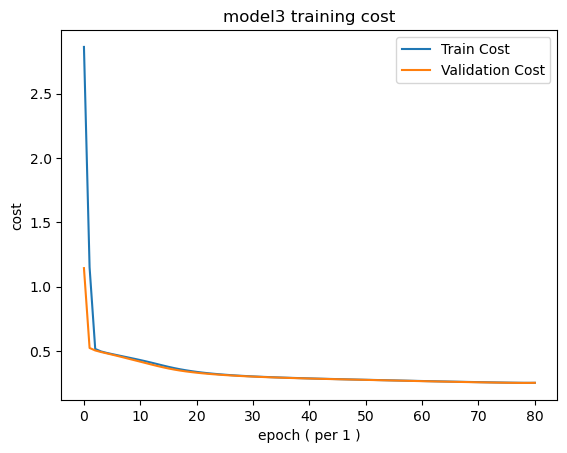

,trip_duration,trip_duration_actural
67250,718.725779,1040
1397036,620.938270,827
1021087,577.795993,614
951424,583.351579,867
707882,2777.411620,4967
...,...,...
526279,556.052721,395
80354,543.683842,779
328645,2920.342589,2344
657429,543.683842,393


In [14]:
model3 = L_layer_model_Regression(layer_dims=[6,7,2,1],active_function='relu',learning_rate=0.7,random_state=12)
model3.fit(X_train_sd,y_train_sd,print_cost=True)
test_pred_sd3 = model3.predict(X_test_sd)

#Convert the test prediction data back to the original scale
test_pred_normal3 = scaler1.inverse_transform(test_pred_sd3)
test_score3 = mean_squared_log_error( y_test_act_1,abs(test_pred_normal3))
print(f'RMSLE of test set = {test_score3}')

show_score(model3,'model3 training cost',times=1)

test_pred_df3 = pd.DataFrame(test_pred_normal3, columns=['trip_duration'])
test_pred_df3.index = y_test_act.index
test_pred_df3["trip_duration_actural"] = y_test_act["trip_duration"]

test_pred_df3

**it trains 3 epochs, and the score on the test set is 0.4427**